In [59]:
import mikeio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pynori.plotter import scatter
from pyplume.plotting.matplotlib_shell import subplots, dhi_colors

# Load model results

In [2]:
def depth_corrector(coordinates, correction_value, change_sign=False):
    coordinates[:, 2] = coordinates[:, 2] + correction_value
    if change_sign:
        coordinates[:, 2] = -coordinates[:, 2]
    return coordinates

In [3]:
def get_layers(coordinates):
    layers = np.unique(coordinates[:, 2])
    return layers

In [4]:
def find_layer_coordinates(coordinates, layers, layer_no):
    layer = layers[layer_no]
    layer_coordinates = coordinates[coordinates[:, 2] == layer]
    layer_indices = np.where(coordinates[:, 2] == layer)[0]
    return layer_indices, layer_coordinates

In [21]:
def find_closest_layer_index(layers, observation_depth):
    if observation_depth < layers[0]:
        return np.nan
    if observation_depth > layers[-1]:
        return np.nan
    return np.argmin(np.abs(layers - observation_depth))

In [24]:
def find_values_within_radius(layer_values, layer_coordinates, observation_coordinates, radius):
    distances = np.sqrt((layer_coordinates[:, 0] - observation_coordinates[0]) ** 2 + (layer_coordinates[:, 1] - observation_coordinates[1]) ** 2)
    return layer_values[distances < radius]

In [46]:
def get_plotting_data(X, Y):
    unique_Y = np.unique(Y)
    unique_X = []
    for i, y in enumerate(unique_Y):
        unique_X.append(np.max(X[Y == y]))
    unique_X = np.array(unique_X)
    data = np.vstack((unique_X, unique_Y)).T
    data = data[data[:, 1].argsort()]
    return data

In [5]:
model_pr1 = r"\\USDEN1-STOR.DHI.DK\Projects\41806287\Models\Midwater\05_runs\rev3\midwater_plume_pr1test.m3fm - Result Files\MT_3D_Items\Total SSC.dfsu"
dfsu = mikeio.read(model_pr1)[0]

100%|██████████| 1891/1891 [00:27<00:00, 68.17it/s]


In [12]:
element_coordinates = dfsu.geometry.element_coordinates.copy()
depth_correction = -1200
change_sign = True
element_coordinates = depth_corrector(element_coordinates, depth_correction, change_sign)
layers = get_layers(element_coordinates)
values = dfsu.values.copy()
times = dfsu.time.copy()

In [8]:
ROV = pd.read_csv(r"\\USDEN1-STOR.DHI.DK\Projects\41806287\41806287 NORI-D Data\Workflow Execution\ROV CTD Calibration\observations\ROV\near field\01_near_field_ROV_CTD.csv", index_col=0, parse_dates=True)
ROV_x = ROV["ROV Easting"].to_numpy().copy()
ROV_y = ROV["ROV Northing"].to_numpy().copy()
ROV_z = ROV["ROV Depth"].to_numpy().copy()
ROV_coordinates = np.vstack((ROV_x, ROV_y, ROV_z)).T
ROV_time = ROV.index.copy()
ROV_values = ROV["SSC (mg/L)"].to_numpy().copy()

In [68]:
outputs = {"Depth": [], "Min": [], "P1": [], "P5": [], "P10": [], "Mean": [], "P90": [], "P95": [], "P99": [], "Max": []}
radius = 100
time_intersection = times.intersection(ROV_time)
n_points = []
for i, time in enumerate(time_intersection):
    time_index = np.where(times == time)[0][0]
    ROV_time_index = np.where(ROV_time == time)[0][0]
    ROV_depth = ROV_coordinates[ROV_time_index, 2]
    ROV_xy = ROV_coordinates[ROV_time_index, :2]
    layer_index = find_closest_layer_index(layers, ROV_depth)
    if np.isnan(layer_index):
        continue
    layer_indices, layer_coordinates = find_layer_coordinates(element_coordinates, layers, layer_index)
    layer_values = values[time_index, layer_indices]
    output_values = find_values_within_radius(layer_values, layer_coordinates, ROV_xy, radius)
    if len(output_values) == 0:
        continue
    outputs["Depth"].append(layers[layer_index])
    outputs["Min"].append(np.min(output_values))
    outputs["P1"].append(np.percentile(output_values, 1))
    outputs["P5"].append(np.percentile(output_values, 5))
    outputs["P10"].append(np.percentile(output_values, 10))
    outputs["Mean"].append(np.mean(output_values))
    outputs["P90"].append(np.percentile(output_values, 90))
    outputs["P95"].append(np.percentile(output_values, 95))
    outputs["P99"].append(np.percentile(output_values, 99))
    outputs["Max"].append(np.max(output_values))
    print(len(output_values))
    n_points.append(len(output_values))
outputs = pd.DataFrame(outputs)
outputs.set_index("Depth", inplace=True)
outputs = outputs * 1000

77
78
84
77
80
77
76
78
73
77
76
76
80
76
81
81
79
81
80
81
82
82
79
82
82
81
80
80
80
78
76
79
76
78
75
74
78
79
77
78
78
80
81
79
82
83
85
84
86
82
87
84
85
85
84
83
84
82
78
79
77
80
74
76
74
78
76
76
75
79
77
79
74
75
75
80
79
82
78
83
79
79
79
79
82
81
81
82
78
83
83
84
79
80
77
79
79
79
79
79
79
79
80
79
78
78
77
76
80
79
79
79
79
79
77
79
79
78
80
78
77
78
79
77
78
78
76
75
78
78
78
77
78
78
79
79
78
78
79
78
78
78
79
81
83
80
83
80
84
79
80
80
79
84
81
81
83
79
81
82
79
85
82
83
83
83
83
84
82
82
82
83
82
82
84
84
83
83
83
83
83
83
82
82
82
83
83
84
83
83
83
83
83
83
83
84
83
83
83
82
82
83
82
84
83
83
83
84
83
84
84
84
83
83
82
84
83
83
84
83
83
83
83
84
83
83
83
83
82
84
84
83
84
81
82
78
81
84
81
82
83
80
77
79
76
77
79
78
78
79
77
78
78
78
78
78
78
78
78
78
79
78
78
78
78
77
78
77
78
79
78
77
76
76
77
77
78
78
77
77
77
78
78
78
77
76
75
76
77
77
77
78
78
79
77
79
77
78
77
78
77
78
76
77
77
78
77
77
76
77
78
78
79
78
77
78
79
76
77
77
76
78
77
77
78
76
76
76
77
77
78
77
77
7

In [56]:
outputs.describe()

,Min,P1,P5,P10,Mean,P90,P95,P99,Max
count,5.230000e+02,5.230000e+02,5.230000e+02,5.230000e+02,5.230000e+02,5.230000e+02,5.230000e+02,5.230000e+02,5.230000e+02
mean,8.983771e-02,9.287026e-02,1.052401e-01,1.199032e-01,6.751846e-01,1.566953e+00,1.917156e+00,2.531334e+00,2.686317e+00
std,3.620743e-01,3.710800e-01,4.101974e-01,4.547838e-01,1.793783e+00,5.435227e+00,6.602599e+00,9.061923e+00,9.753170e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.493739e-17,1.169593e-15,2.023964e-15,4.608016e-15,4.246082e-08,5.408925e-08,1.339343e-07,4.988465e-07,5.701679e-07
50%,5.607032e-13,2.211666e-12,9.084803e-12,4.895917e-11,4.684351e-04,9.795063e-04,2.024603e-03,4.101023e-03,4.542210e-03
75%,5.236959e-08,1.268073e-07,3.017247e-07,1.190612e-06,3.216125e-01,5.605247e-01,7.445601e-01,1.880210e+00,2.144390e+00
max,2.567489e+00,2.643561e+00,2.947848e+00,2.989616e+00,1.580499e+01,7.204061e+01,7.697287e+01,1.003461e+02,1.094342e+02


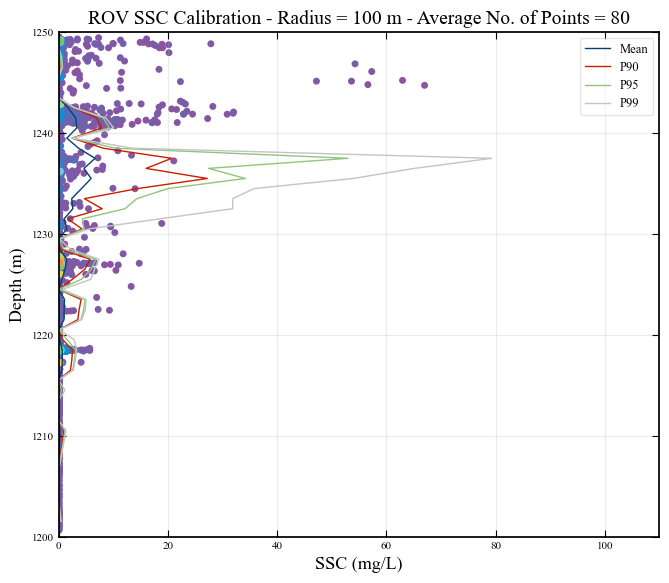

In [69]:
colors = [dhi_colors.blue1, dhi_colors.red1, dhi_colors.green1, dhi_colors.gray1]
fig, ax = subplots()
for col in ["Mean", "P90", "P95", "P99"]:
    data = get_plotting_data(outputs[col].to_numpy().copy(), outputs.index.to_numpy().copy())
    ax.plot(data[:, 0], data[:, 1], label=col, linewidth=1, color=colors.pop(0))

mask = (ROV_coordinates[:, 2] > np.min(layers)) & (ROV_coordinates[:, 2] < np.max(layers))
fig, ax = scatter(ROV_values[mask], ROV_coordinates[mask, 2], np.arange(0, 71, 5), np.arange(1200, 1251, 2), fig=fig, ax=ax)
ax.set_xlim(0, 110)
ax.set_ylim(1200, 1250)
ax.set_xlabel("SSC (mg/L)")
ax.set_ylabel("Depth (m)")
ax.set_title(f"ROV SSC Calibration - Radius = {radius} m - Average No. of Points = {int(np.mean(n_points))}")
ax.legend()
fig.savefig(f"ROV_SSC_Calibration_Radius_{radius}.png", dpi=600)

In [39]:
np.arange(1200, 1250)

array([1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210,
       1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221,
       1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232,
       1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243,
       1244, 1245, 1246, 1247, 1248, 1249])

0.0


Text(0.5, 1.0, 'ROV SSC Calibration')

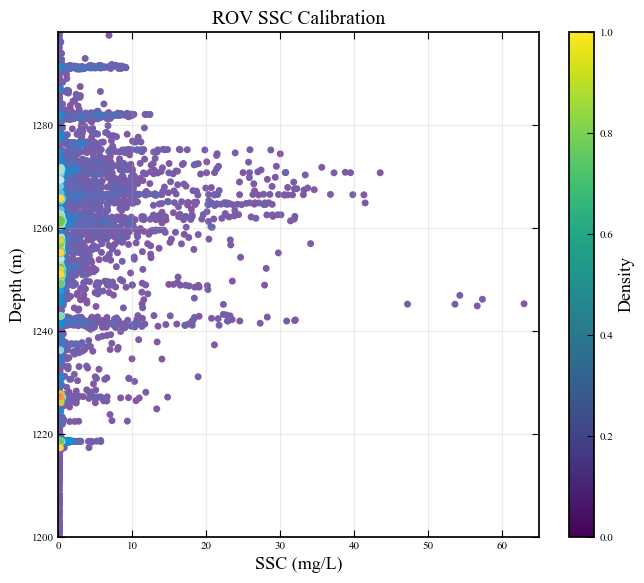

In [20]:
fig, ax = scatter(ROV_SSC, ROV_depth, ROV_SSC_bins, ROV_depth_bins)
ax.set_xlabel("SSC (mg/L)")
ax.set_ylabel("Depth (m)")
ax.set_title("ROV SSC Calibration")